In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
from keras.layers import Dense, Dropout, Conv1D, Flatten
import keras_tuner as kt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras.backend as K
import smogn
from math import ceil
from config_file import *
from graph_model import *
from ann_visualizer.visualize import ann_viz

In [2]:
# Disabling this warning as we only need part of the data
# So we copy 'measurements_df' -> 'measurements_subset'
pd.options.mode.chained_assignment = None

In [3]:
#Load datasets
config = Config()
surfer_datasets = config.all_paths_list()

# Currently using only the first dataset, should investigate all for best feature selection
surfer_dataset = pd.read_csv(surfer_datasets[0])

if 'servertime' in surfer_dataset.columns:
    surfer_dataset = surfer_dataset.drop(columns=['servertime'])
print(surfer_dataset)

                          time   latitude  longitude  HDT - Heading True  \
0      2023-03-07 07:52:56.599  29.541469  34.948042              155.29   
1      2023-03-07 07:52:57.599  29.541472  34.948040              175.53   
2      2023-03-07 07:52:58.599  29.541474  34.948039              329.34   
3      2023-03-07 07:52:59.599  29.541475  34.948037               63.35   
4      2023-03-07 07:53:00.599  29.541475  34.948035              346.68   
...                        ...        ...        ...                 ...   
22404  2023-03-07 14:06:24.599  29.541548  34.948055              286.88   
22405  2023-03-07 14:06:25.599  29.541548  34.948055              277.17   
22406  2023-03-07 14:06:26.499  29.541548  34.948055              256.45   
22407  2023-03-07 14:06:27.599  29.541548  34.948055              302.56   
22408  2023-03-07 14:06:28.599  29.541548  34.948055              302.98   

       SOG - Speed over Ground  COG - Course over Ground  \
0                     0.036

### a. Correlation between collected surfer's data features:

In [4]:
surfer_dataset['water_current'] = surfer_dataset['HDT - Heading True']-surfer_dataset['COG - Course over Ground']

In [5]:
surfer_subset = surfer_dataset[['HDT - Heading True', 'SOG - Speed over Ground', 'Heel', 'Trim Fore / Aft','water_current']]
list_of_cols = surfer_subset.columns.tolist()
#list_of_cols.remove('time')
label_cols = ['SOG - Speed over Ground']
list_of_cols.remove(label_cols[0])

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

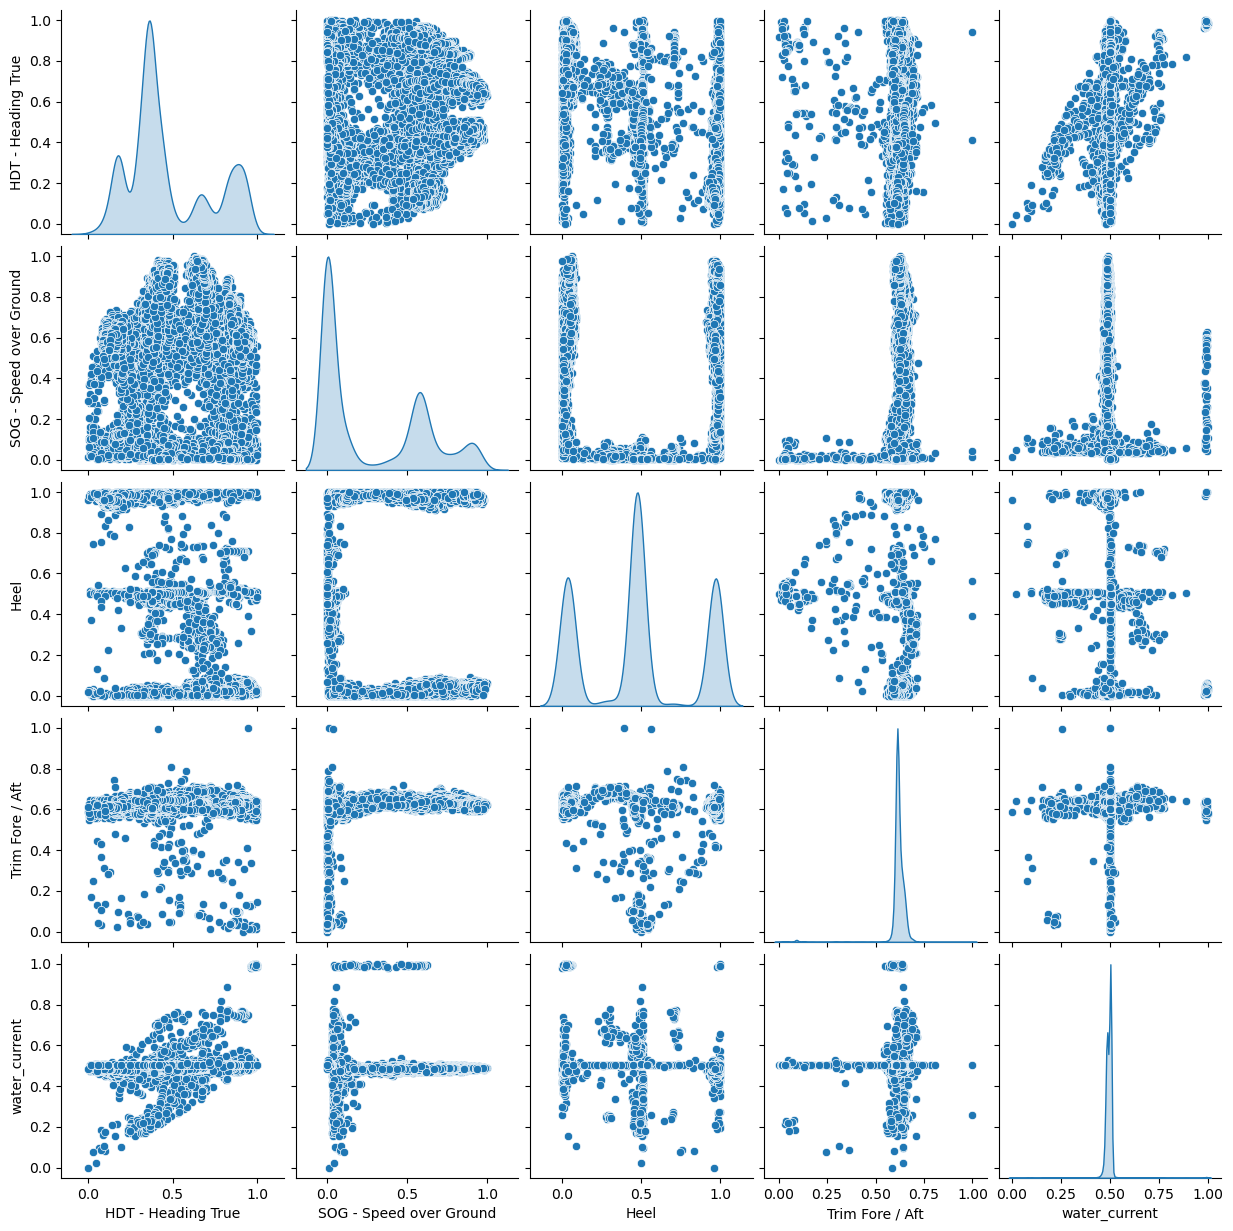

In [6]:
surfer_subset[list_of_cols] = pd.DataFrame(x_scaler.fit_transform(surfer_subset[list_of_cols]), columns=list_of_cols)
surfer_subset[label_cols] = pd.DataFrame(y_scaler.fit_transform(surfer_subset[label_cols]), columns=label_cols)
train_dataset = surfer_subset.sample(frac=0.8, random_state=0)
test_dataset = surfer_subset.drop(train_dataset.index)
sns.pairplot(surfer_subset[surfer_subset.columns], diag_kind='kde')
plt.show()

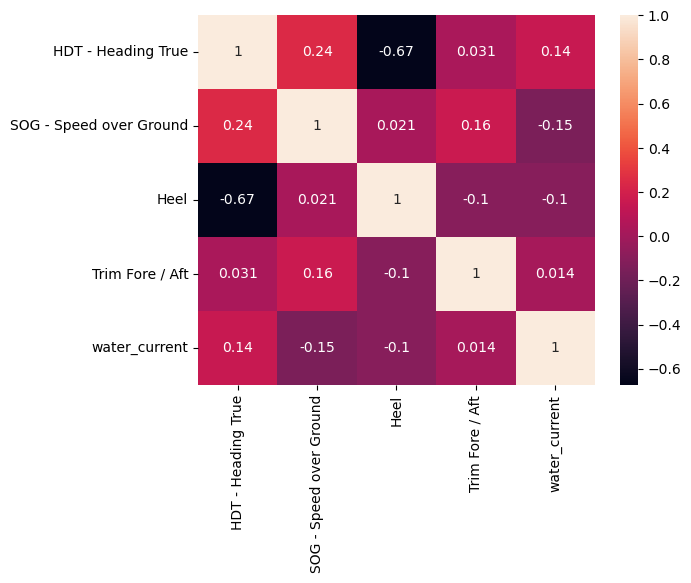

In [7]:
sns.heatmap(surfer_subset.corr(), annot=True)
plt.show()

In [8]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('SOG - Speed over Ground')
test_labels = test_features.pop('SOG - Speed over Ground')

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [9]:
lr_list = np.logspace(-7.5, -3.5, 9)
splits = 10
#_best_lr = None
_best_lr = 6e-6

model = tf.keras.Sequential([
    Dense(128, activation='relu'),
    Dropout(0.15),
    Dense(128, activation='relu'),
    Dense(1),
])

surfer_inputs = np.concatenate((train_features, test_features), axis=0)
surfer_targets = np.concatenate((train_labels, test_labels), axis=0)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [10]:
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def build_and_compile_model(lr, model, inputs, targets):
    acc_per_fold = []
    loss_per_fold = []
    histories = []
    fold_no = 1
    kf = KFold(n_splits = splits)
    for train, test in kf.split(inputs, targets):
        model.compile(
            # Test different learning rates and print results
            optimizer=tf.optimizers.Adam(learning_rate=lr),
            loss="mean_squared_error",
            metrics=[soft_acc]
        )
        histories.append(model.fit(inputs[train], targets[train], epochs=50, verbose=0))
        scores = model.evaluate(inputs[test], targets[test], verbose=0)
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        fold_no = fold_no + 1
    return (histories, loss_per_fold, acc_per_fold)

In [11]:
def compile_model(model,inputs,targets, lr_list, best_lr = None):
    results = []
    for lr in lr_list:
        if best_lr is not None:
            results.append(build_and_compile_model(best_lr,model,inputs,targets))
            print(model.summary())
            scores_per_fold(results)
            break
        print(f"Current lr: {round(lr,10)}")
        results.append(build_and_compile_model(round(lr,10),model,inputs,targets))
    return results

In [12]:
def scores_per_fold(results):
    if _best_lr is not None:
        print('------------------------------------------------------------------------')
        print('Score per fold')
        for i in range(len(results[0][2])):
            print('------------------------------------------------------------------------')
            print(f'> Fold {i+1} - Loss: {results[0][1][i]} - Accuracy: {results[0][2][i]}%')
        print('------------------------------------------------------------------------')
        print('Average scores for all folds:')
        print(f'> Accuracy: {np.mean(results[0][2])} (+- {np.std(results[0][2])})')
        print(f'> Loss: {np.mean(results[0][1])}')
        print('------------------------------------------------------------------------')

In [13]:
def show_nine_losses(results, lr_list, title=""):
    fig, axs = plt.subplots(3,3, figsize=(10, 6))
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(title, fontsize=16, y=1.05)
    axs = np.ravel(axs)
    for i,lr in enumerate(lr_list):
        avg_loss_per_epoch = [0 for i in range(len(results[0][0][0].history['loss']))] #epochs
        for hist in results[i][0]:
            avg_loss_per_epoch= [x + y for x, y in zip(avg_loss_per_epoch, hist.history['loss'])]
        avg_loss_per_epoch = [x/len(results[0][0]) for x in avg_loss_per_epoch]
        axs[i].plot(avg_loss_per_epoch, label='loss')
        axs[i].set_title(f'lr={round(lr,8)}')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel('Loss')
        axs[i].legend()
        axs[i].grid(True)
    plt.show()

def show_single_loss(results, lr, title="", legend='loss'):
    fig, ax = plt.subplots(figsize=(10, 6))
    avg_loss_per_epoch = [0 for i in range(len(results[0][0][0].history['loss']))]
    for hist in results[0][0]:
        avg_loss_per_epoch= [x + y for x, y in zip(avg_loss_per_epoch, hist.history['loss'])]
    avg_loss_per_epoch = [x/len(results[0][0]) for x in avg_loss_per_epoch]
    plt.tight_layout()
    fig.suptitle(title, fontsize=16, y=1.05)
    ax.plot(avg_loss_per_epoch, label='loss')
    ax.set_title(f'lr={lr}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(title=legend)
    ax.grid(True)
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
_________________________________________________________________
None
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.03604290261864662 - Accuracy: 79.7535240650177%
-----------------

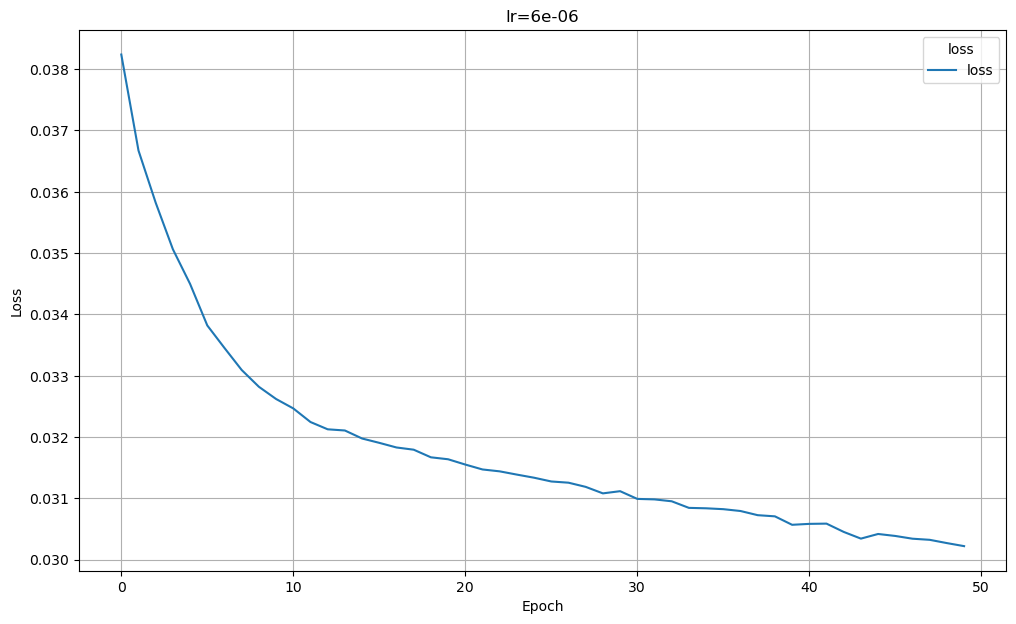

In [14]:
surfer_results = compile_model(model,surfer_inputs,surfer_targets,lr_list,_best_lr)
if _best_lr is not None:
    show_single_loss(surfer_results, _best_lr)
else:
    show_nine_losses(surfer_results,lr_list)

In [15]:
test_preds = y_scaler.inverse_transform(model.predict(test_features))
test_real_labels = y_scaler.inverse_transform(test_labels.values.reshape(-1,1))

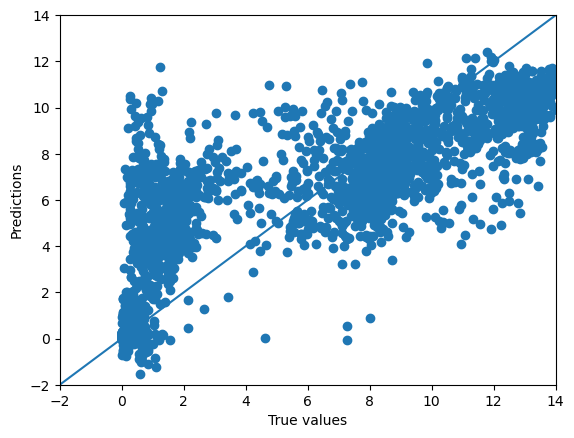

In [16]:
plt.scatter(test_real_labels, test_preds)
plt.xlabel("True values")
plt.ylabel("Predictions")
lims = [-2,14]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims,lims)
plt.show()

# Note: The reason we see many wrongly predicted values not equal to 0 is because
#       of reasons such as stopping which is not related to numerical behaviour.
#       Should add more visualization on the graph such as time stamp of the true value as cmap

### b. Correlation between DIC and pressure measurements:

In [17]:
%store -r norm_wings_dic_df
%store -r measurements_subset
print(norm_wings_dic_df)
print(measurements_subset)

          bend slopes_1  bend slopes_2  bend slopes_3  bend slopes_4  \
itemName                                                               
DP2            0.474576       0.144672       0.473061       0.117890   
MM3            0.659969       0.515439       0.634003       0.607555   
MM4            0.444614       0.266712       0.334752       0.351196   
NG1            0.500593       0.340951       0.462963       0.441396   
NM1            0.000000       0.597290       0.000000       0.593629   
NM2            0.455417       0.211991       0.399988       0.179938   
SK3            0.535796       0.241127       0.503117       0.152317   
ST2            0.623792       0.503806       0.655743       0.675879   
ST3            0.212471       0.197529       0.262755       0.135784   
TR3            1.000000       1.000000       0.970789       1.000000   
TR4            0.715299       0.611970       0.726804       0.628955   
TR5            0.621474       0.448179       0.613004       0.34

In [18]:
measurements_subset['parts'].loc[measurements_subset['parts']=='twist back'] = 'twistBack'
measurements_subset['parts'].loc[measurements_subset['parts']=='twist front'] = 'twistFront'
measurements_subset['force (N)'] = pd.to_numeric(measurements_subset['force (N)'])
# Retain only the score and symmetric data in DIC df
wings_dic_df = norm_wings_dic_df.loc[:, [col for col in norm_wings_dic_df.columns if any([x in col for x in ['score','symetric']])]]
wings_measurement_df = measurements_subset.drop(measurements_subset[measurements_subset.item == 'mast'].index)
masts_dic_df = None
masts_measurement_df = measurements_subset.drop(wings_measurement_df.index)

# Same score columns, doesn't matter which we choose
labels = wings_dic_df.columns
labels = [l for l in labels if 'is_symetric' not in l]
surfer_features = ['bend','twistBack','twistFront']

In [19]:
def make_df_list(measurement_df, dic_df):
    categorized_df_by_list = []
    removed_surfers = set([])
    for feature in surfer_features:
        f_label = [s for s in labels if feature in s]
        for l in f_label:
            f_df = measurement_df.loc[measurement_df['parts'] == feature]
            scores = dic_df[l].index
            f_df[l] = np.nan
            for idx in scores:
                # Should change it to inner join, more efficient
                f_df[l].loc[f_df.item_name == idx] = dic_df[l][idx]

            # Manual fix for miswritten surfer's name
            f_df[l].loc[f_df['item_name'] == 'YO1-2'] = dic_df[l]['YO1b']

            # Remove all surfers which wasn't found on the dic df, save them for further investigation
            inds = f_df.loc[pd.isna(f_df[l]), :].index
            removed_surfers.update([x for x in f_df['item_name'][inds]])
            f_df.dropna(subset=[l], inplace=True)

            # Standarization
            f_df = f_df.drop(columns=['parts','part_name','item','item_name','frame'])
            f_df = f_df.apply(zscore)

            categorized_df_by_list.append((l,f_df))
    return (categorized_df_by_list, removed_surfers)

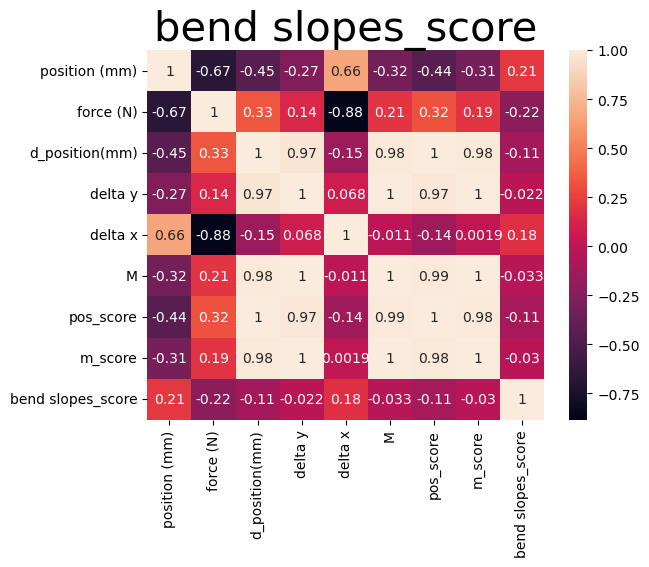

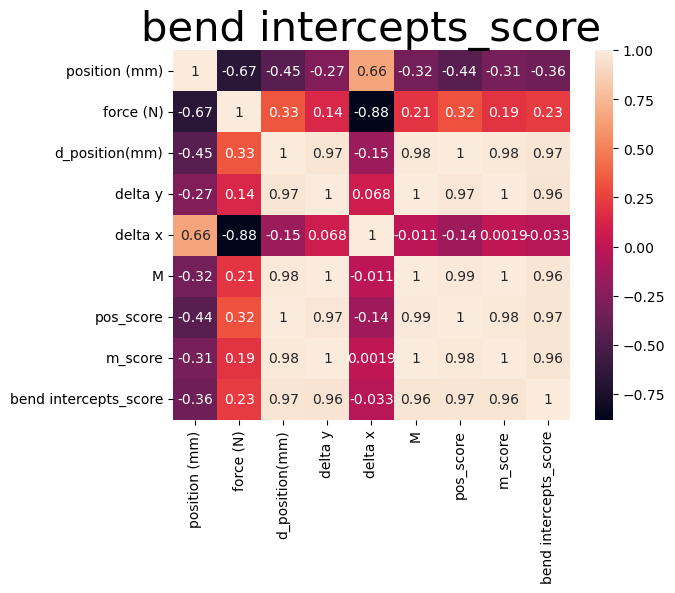

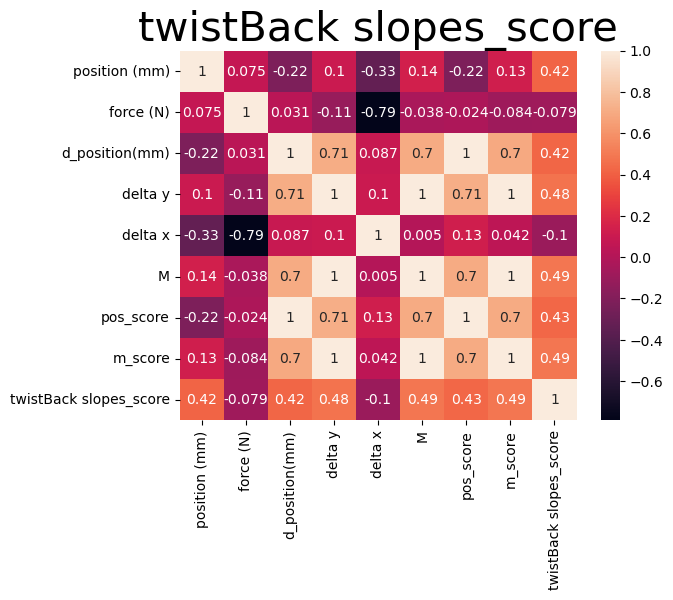

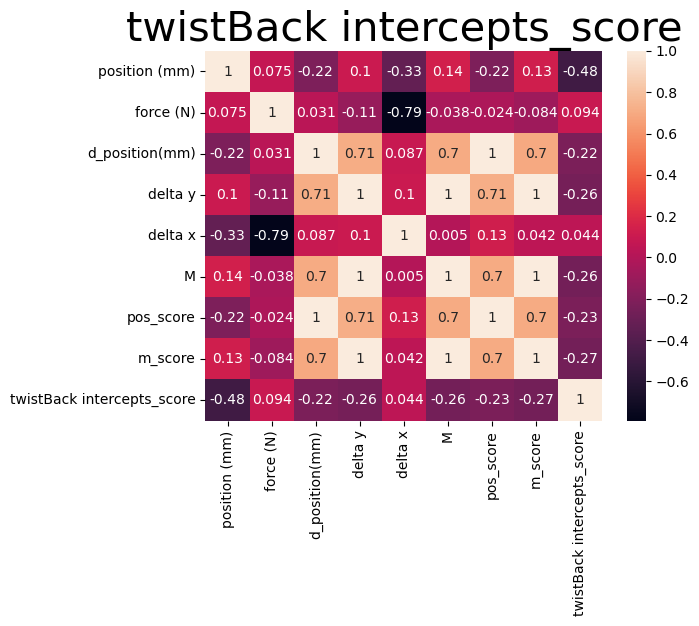

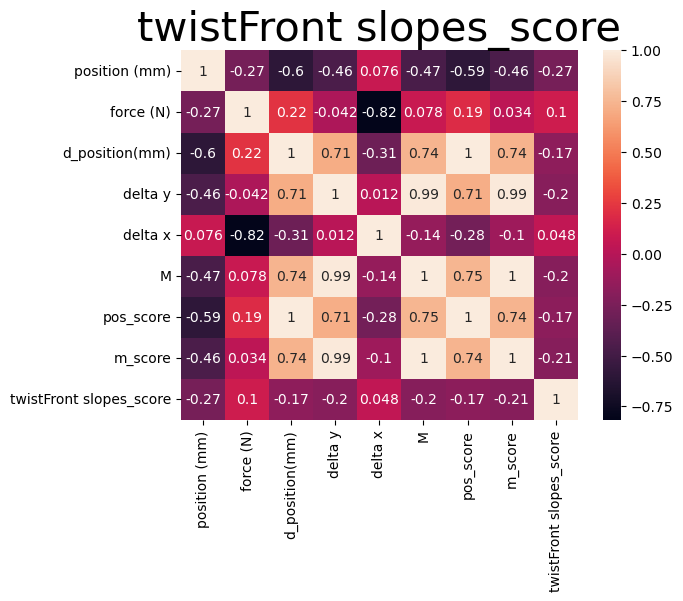

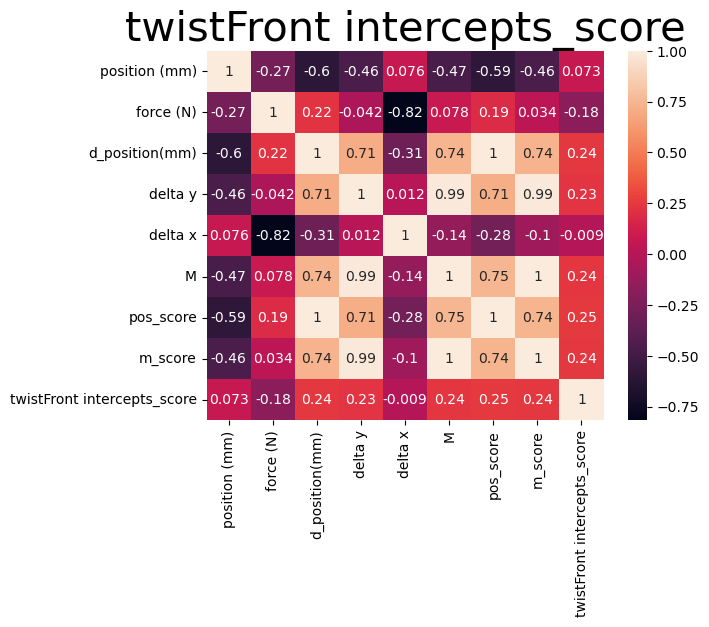

In [20]:
wings_list_of_df, wings_nan_surfers = make_df_list(wings_measurement_df,wings_dic_df)
lr_list = np.logspace(-5, -1, 9)

for df in wings_list_of_df:
    plt.title(label=df[0], fontsize=30)
    sns.heatmap(df[1].corr(), annot=True)
    plt.show()

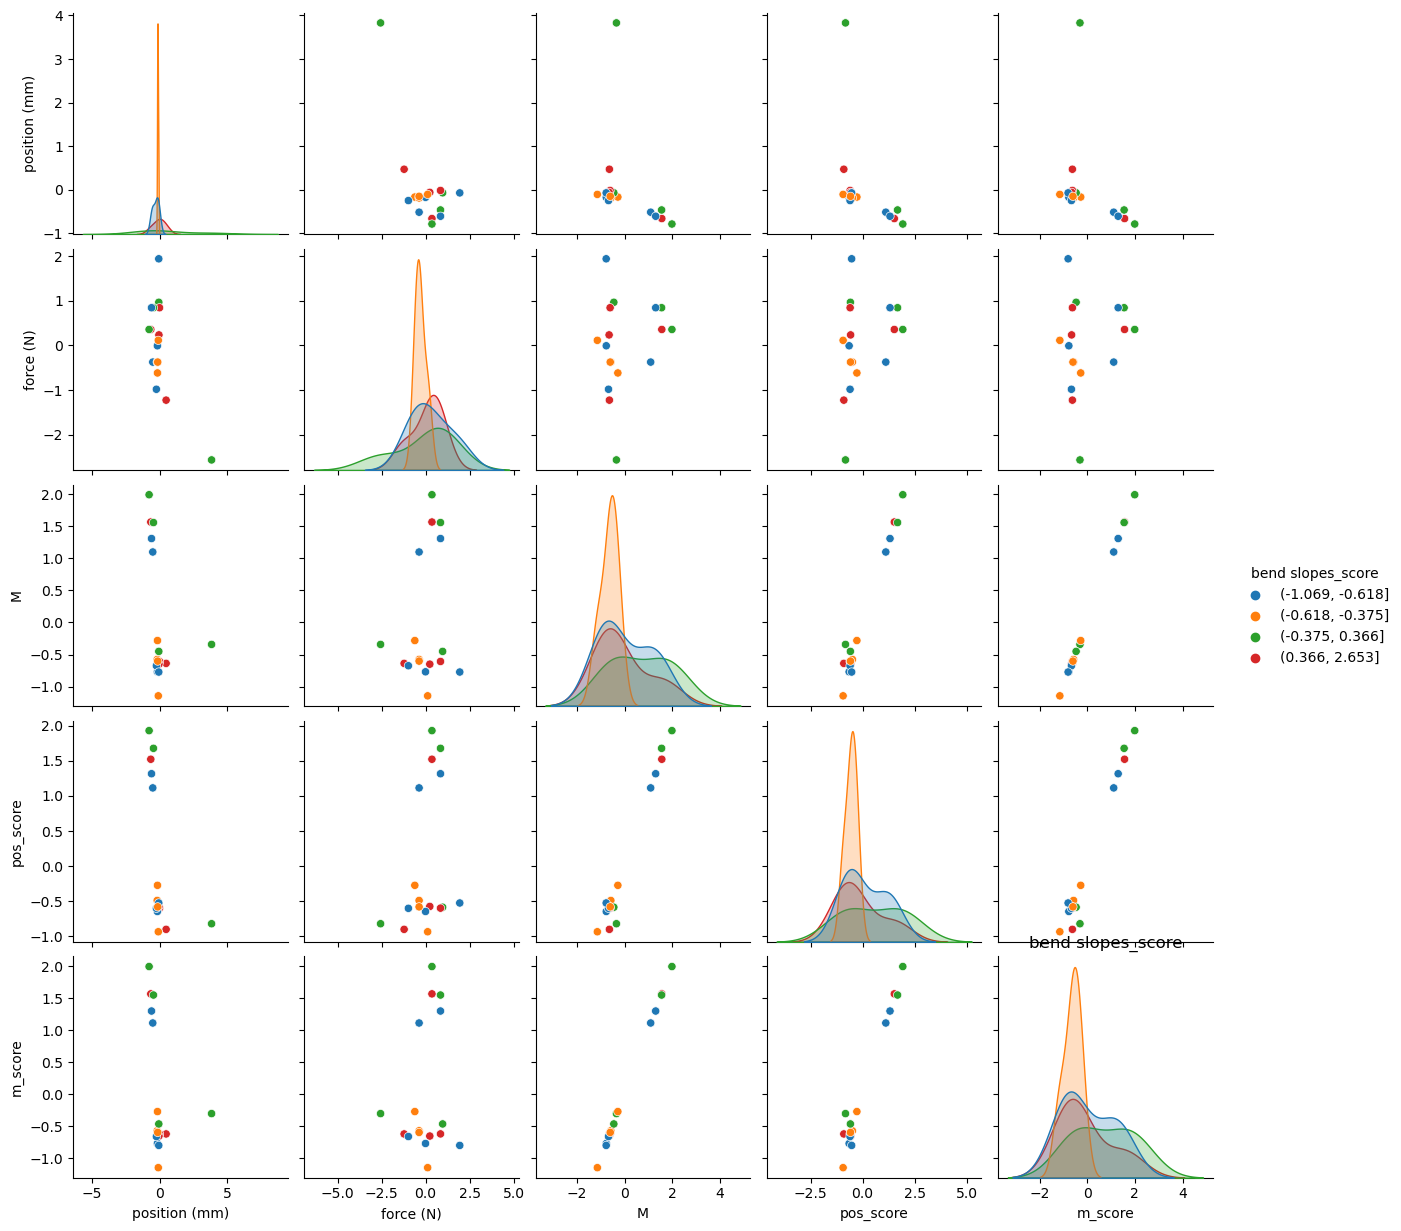

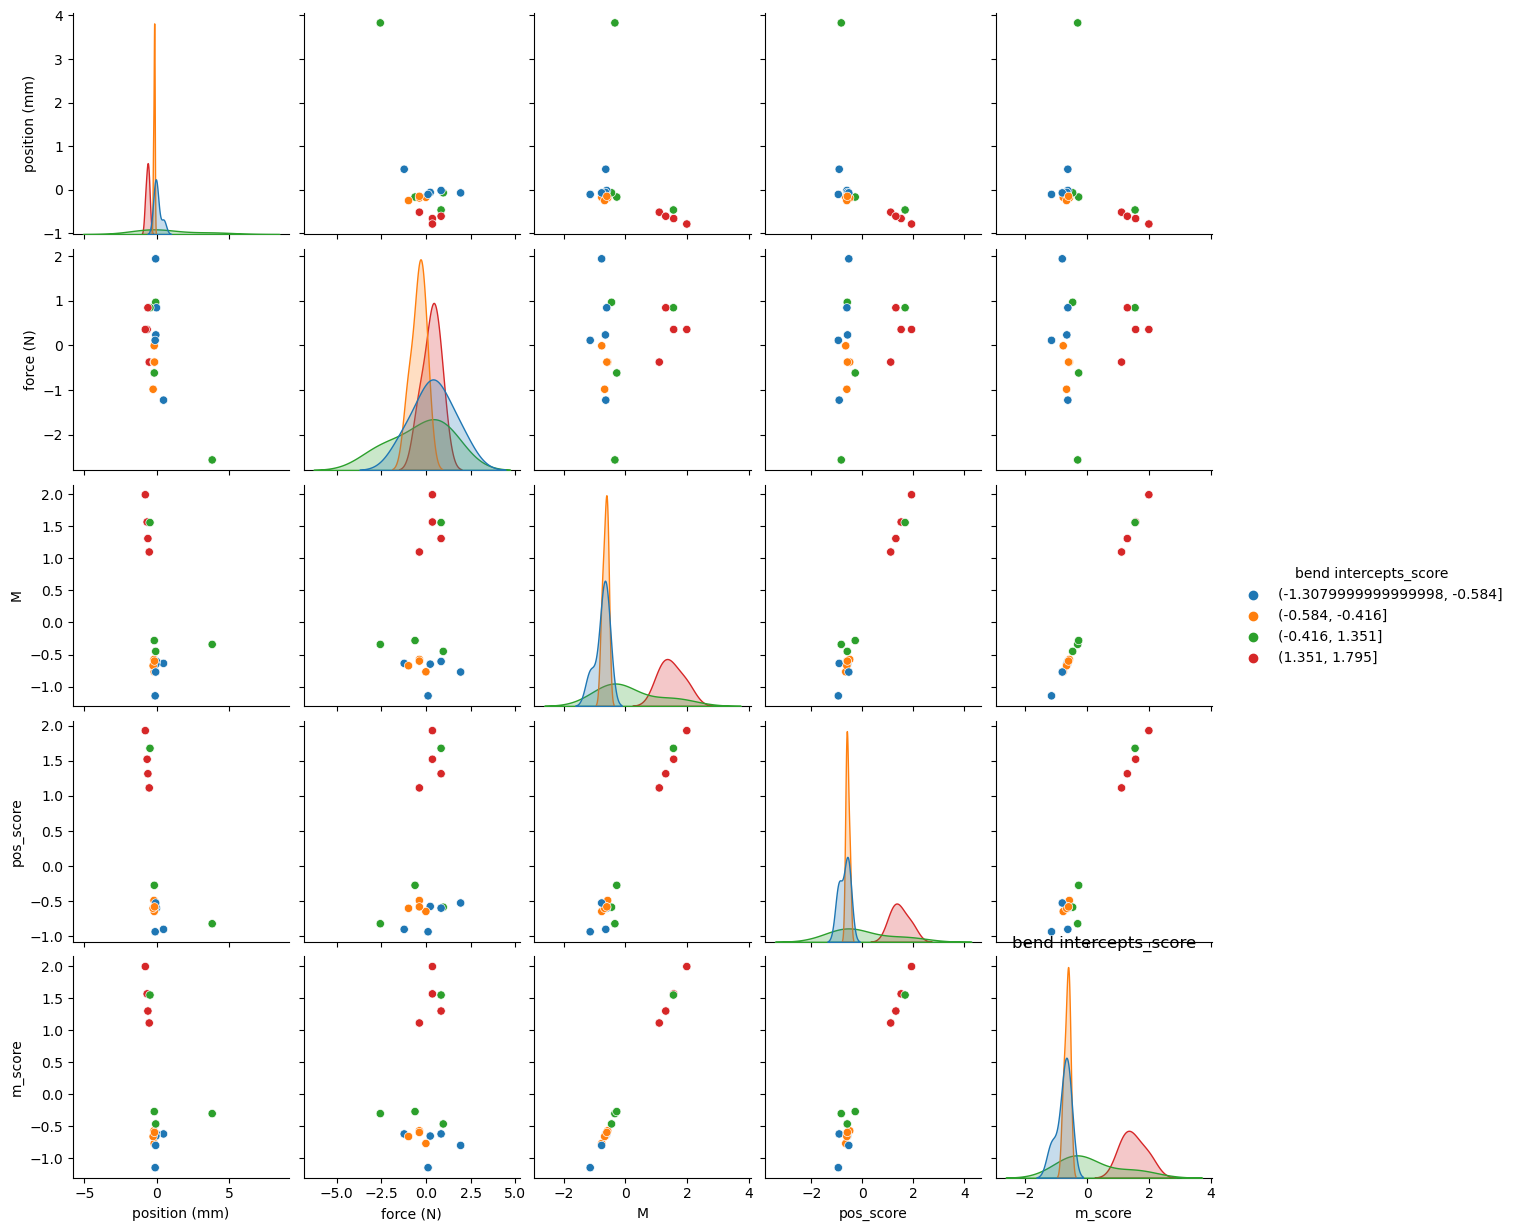

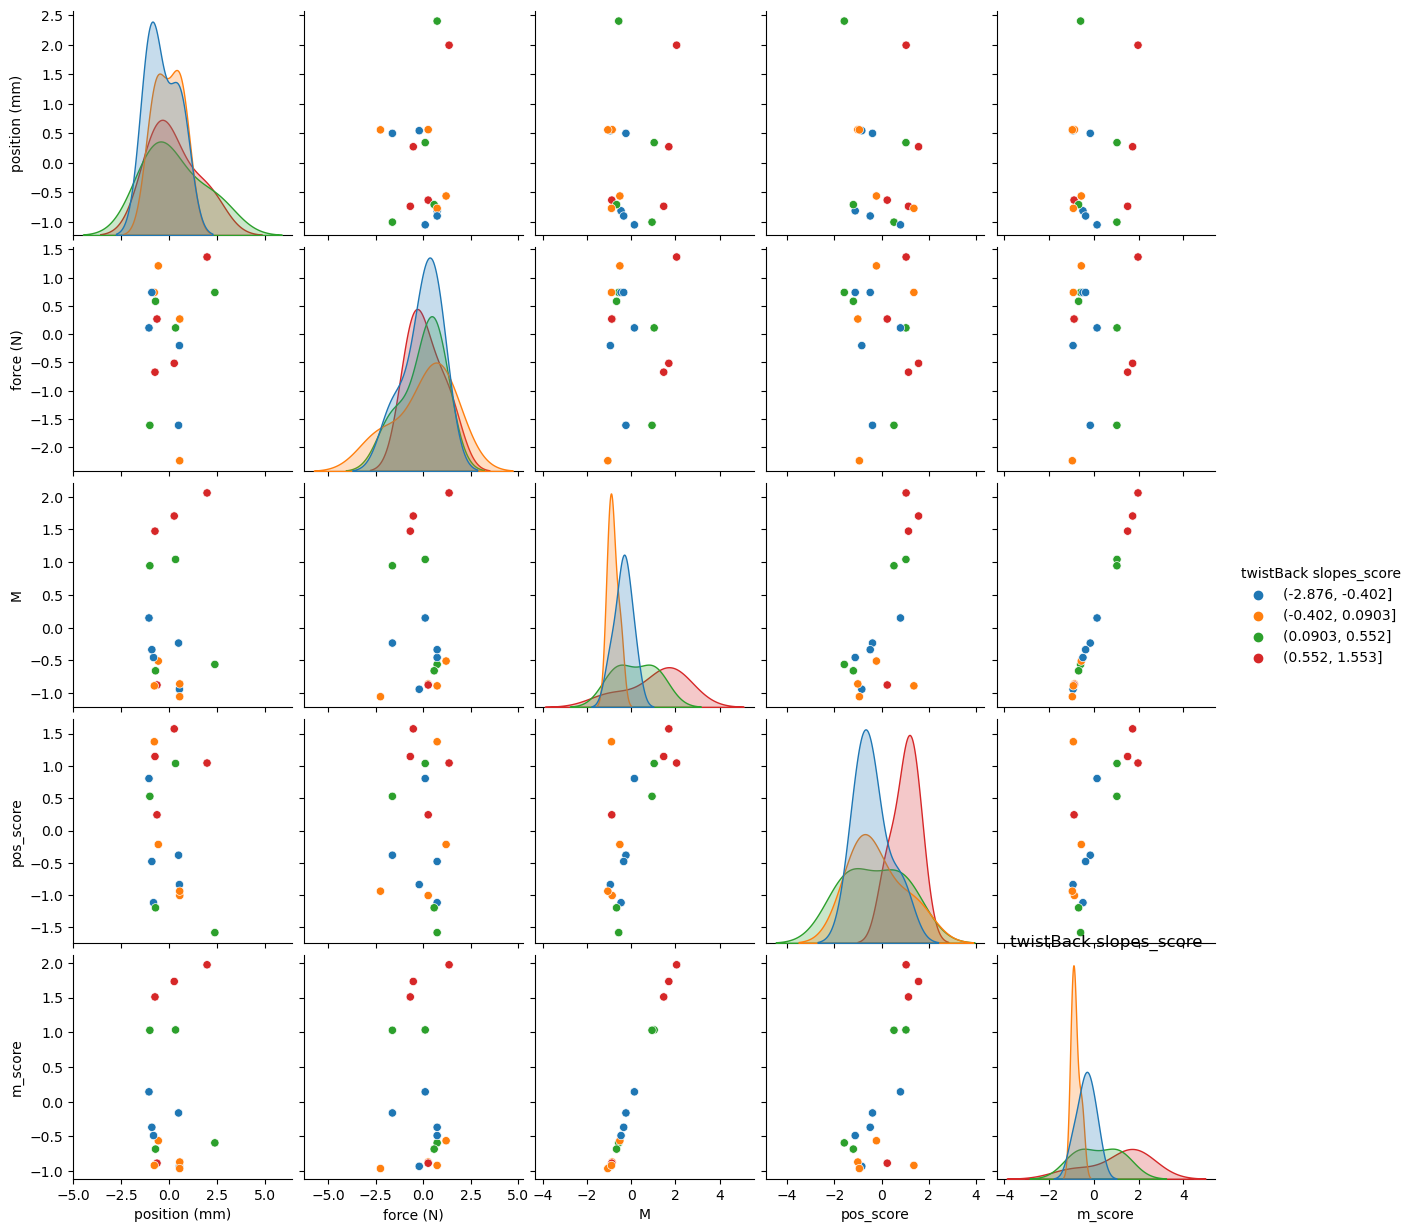

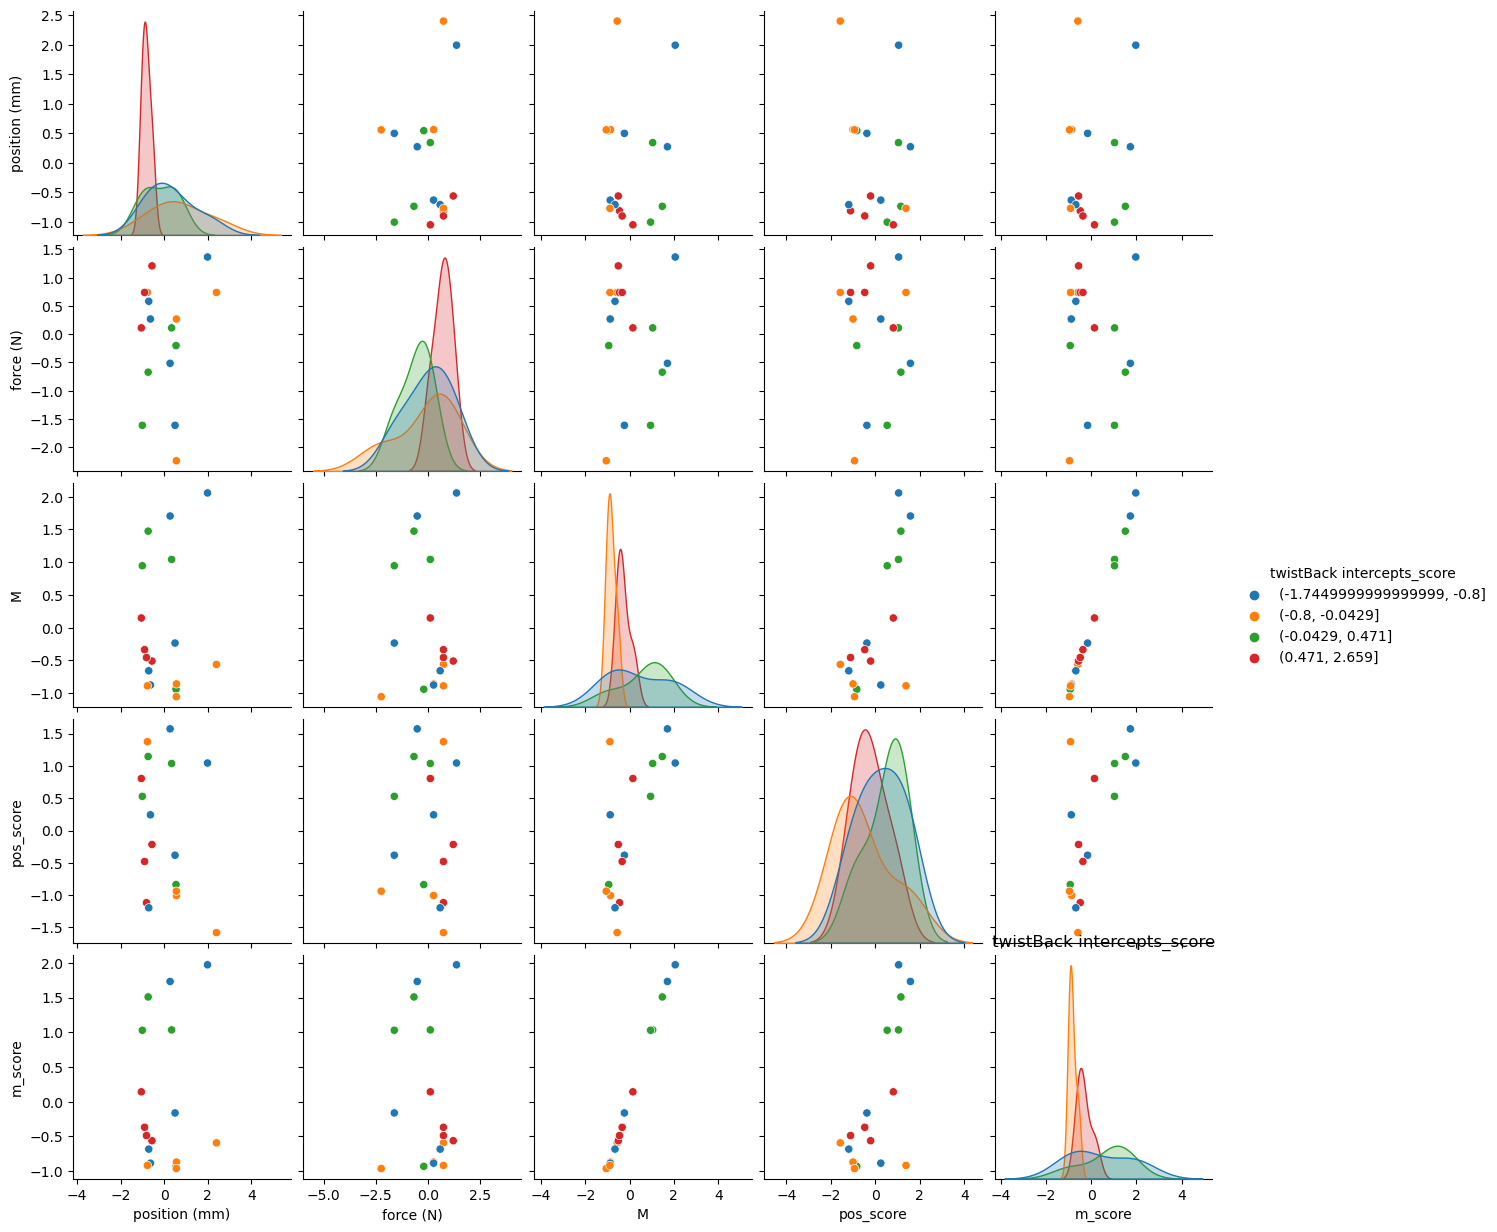

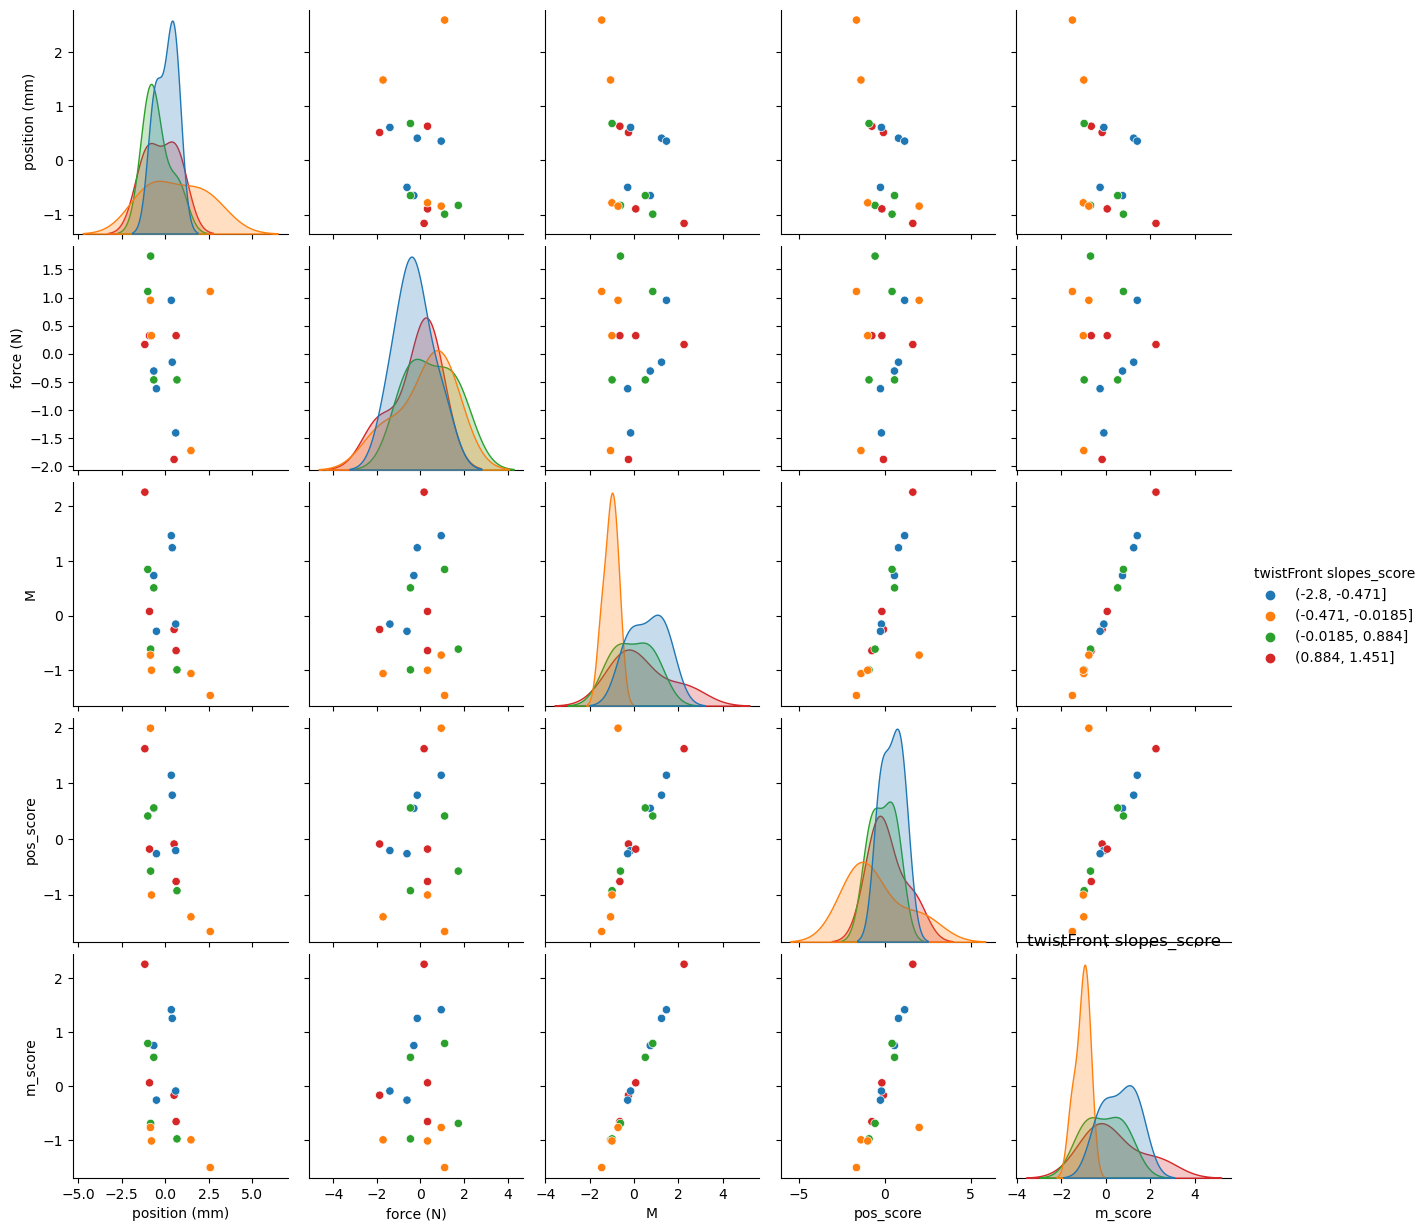

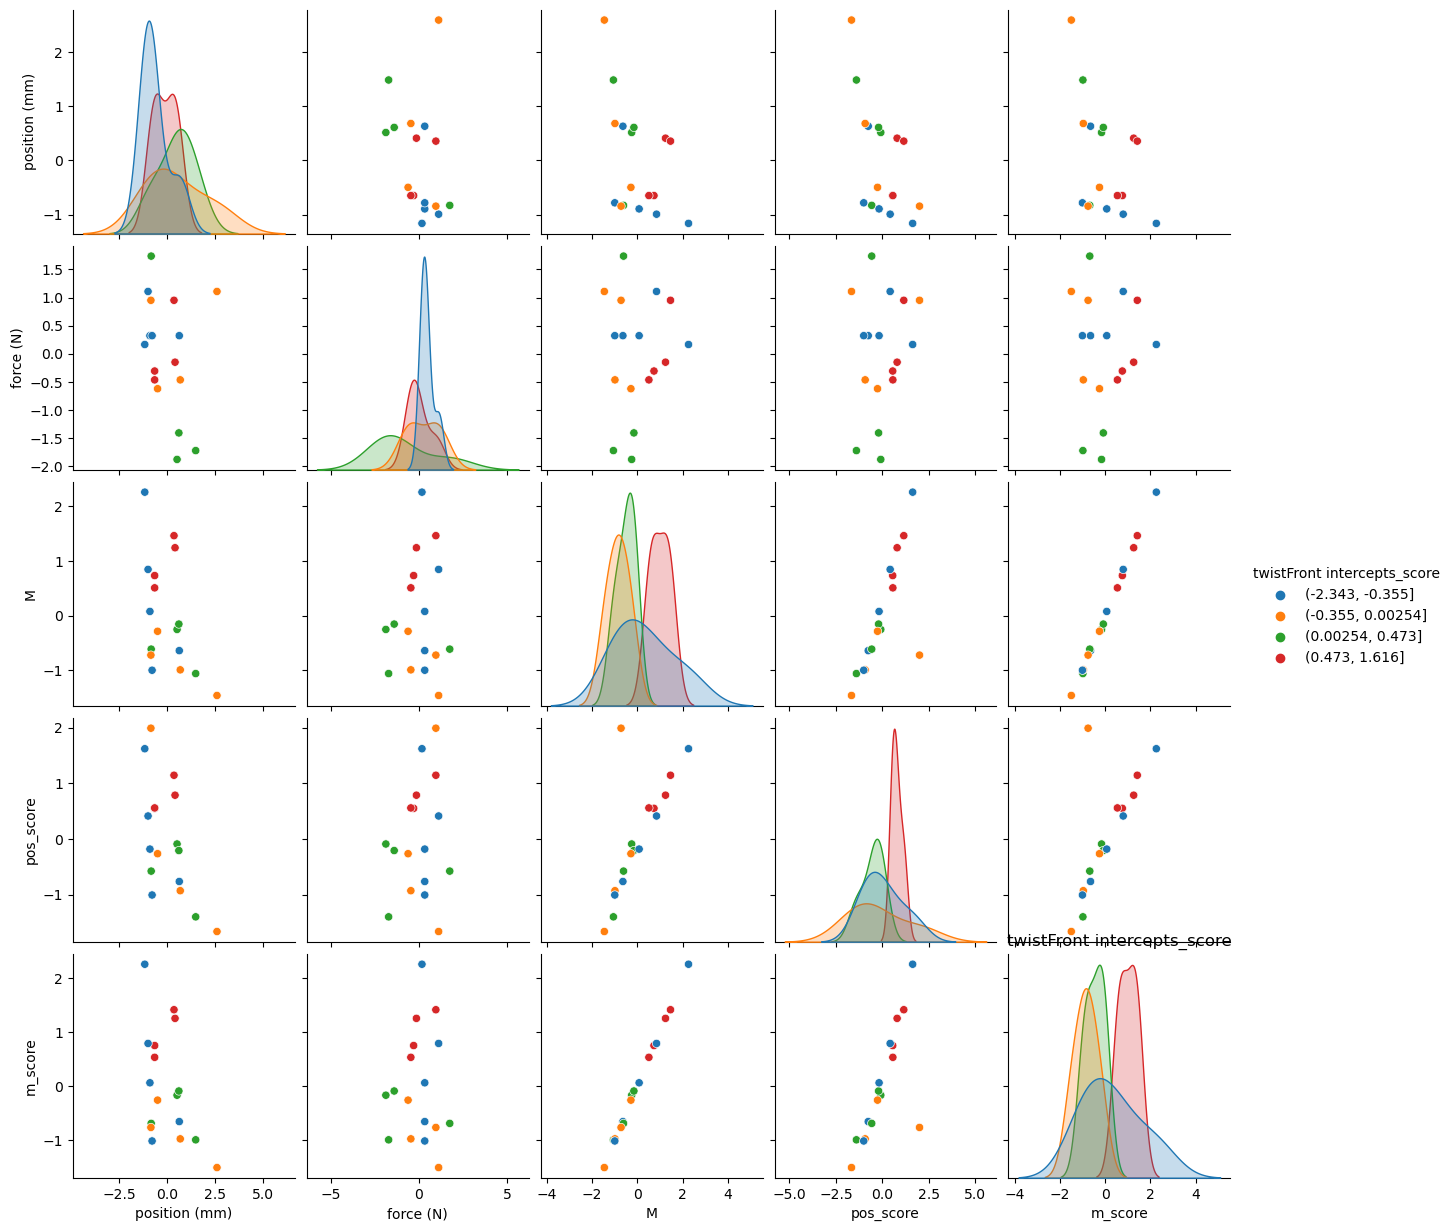

In [21]:
for i, wing_df in enumerate(wings_list_of_df):
    copy_df = wing_df[1].copy()
    label = wing_df[0]
    categorized_label = pd.qcut(copy_df[label], 4)
    copy_df[label] = categorized_label
    copy_df.drop(columns=['delta x','delta y','d_position(mm)'], inplace=True)
    sns.pairplot(copy_df, hue=label)
    plt.title(label=label)
    plt.show()

In [22]:
# Fill manually, rows are according to df_flag
best_lrs = [[0.0001, 0.00006, 0.00006, 0.00003, 0.00007, 0.00006],
            [0.0002, 0.0003, 0.0004, 0.0003, 0.00035, 0.0003],
            [0.001, 0.0007, 0.0008, 0.0008, 0.0015, 0.0015]]
#best_lrs = [None for i in range(len(wings_list_of_df))]

In [23]:
def generate_data_by_smogn(label_name, df_w_label):
    #  For some reason, smote and smogn can't accept negative values
    scalar = MinMaxScaler()

    x = df_w_label.values #returns a numpy array
    x_scaled = scalar.fit_transform(x)
    df = pd.DataFrame(x_scaled, columns=df_w_label.columns)
    smogn_df = smogn.smoter(

        data = df.reset_index(drop=True),
        y = label_name,
        k = 3,
        samp_method = "extreme",
        rel_coef = 0.20
    )
    print(f"Original shape: {df.shape}")
    print(f"Smogn shape: {smogn_df.shape}")
    return smogn_df.reset_index()

In [24]:
def generate_data_by_stats(df):
    new_df = pd.DataFrame(columns=df.columns)
    size = len(df)
    for col in df.columns:
        new_df[col] = generate_col_by_stats(size, df[col].describe()['mean'], df[col].describe()['std'])
    return pd.concat([df, new_df])

def generate_col_by_stats(size, mean, std):

    samples = np.random.normal(loc=0.0, scale=std, size=size)

    actual_mean = np.mean(samples)
    actual_std = np.std(samples)
    print("Initial samples stats   : mean = {:.4f} stdv = {:.4f}".format(actual_mean, actual_std))

    zero_mean_samples = samples - (actual_mean)
    zero_mean_mean = np.mean(zero_mean_samples)
    zero_mean_std = np.std(zero_mean_samples)
    print("True zero samples stats : mean = {:.4f} stdv = {:.4f}".format(zero_mean_mean, zero_mean_std))

    scaled_samples = zero_mean_samples * (std/zero_mean_std)
    scaled_mean = np.mean(scaled_samples)
    scaled_std = np.std(scaled_samples)
    print("Scaled samples stats    : mean = {:.4f} stdv = {:.4f}".format(scaled_mean, scaled_std))

    final_samples = scaled_samples + mean
    final_mean = np.mean(final_samples)
    final_std = np.std(final_samples)
    print("Final samples stats     : mean = {:.4f} stdv = {:.4f}".format(final_mean, final_std))
    return final_samples

In [25]:
def build_df_and_model(df_flag=0):
    #   df_flag: specifies how to generate data based on our dataset
    #
    #   0: Original df
    #   1: Generates data using SMOTE (smogn)
    #   2: Generates data using statistics variables
    all_features_results = []

    for i, wing_df in enumerate(wings_list_of_df):
        label_name, df_w_label = wing_df
        if df_flag == 1:
            df_w_label = generate_data_by_smogn(label_name, df_w_label)
        if df_flag == 2:
            df_w_label = generate_data_by_stats(df_w_label)

        train_df = df_w_label.sample(frac=0.8, random_state=1604)
        test_df = df_w_label.drop(train_df.index)
        train_labels = train_df.pop(label_name)
        test_labels = test_df.pop(label_name)
        surfer_inputs = np.concatenate((train_df, test_df), axis=0)
        surfer_targets = np.concatenate((train_labels, test_labels), axis=0)
        surfer_inputs = surfer_inputs.reshape(-1, surfer_inputs.shape[1],1)
        input_shape = (surfer_inputs.shape[1],1)

        dic_model = tf.keras.Sequential([
            Conv1D(filters = 128,
                   input_shape = input_shape,
                   activation = 'relu',
                   kernel_size = 3),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.1),
            Dense(128, activation='relu'),
            Dense(1),
        ])
        results = compile_model(dic_model, surfer_inputs, surfer_targets, lr_list, best_lrs[df_flag][i])
        all_features_results.append((label_name, results, dic_model, test_df, test_labels))
    return all_features_results

In [26]:
all_features_results_0 = build_df_and_model(df_flag=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 128)            512       
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               98432     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 115,585
Trainable params: 115,585
Non-trainable params: 0
________________________________________________

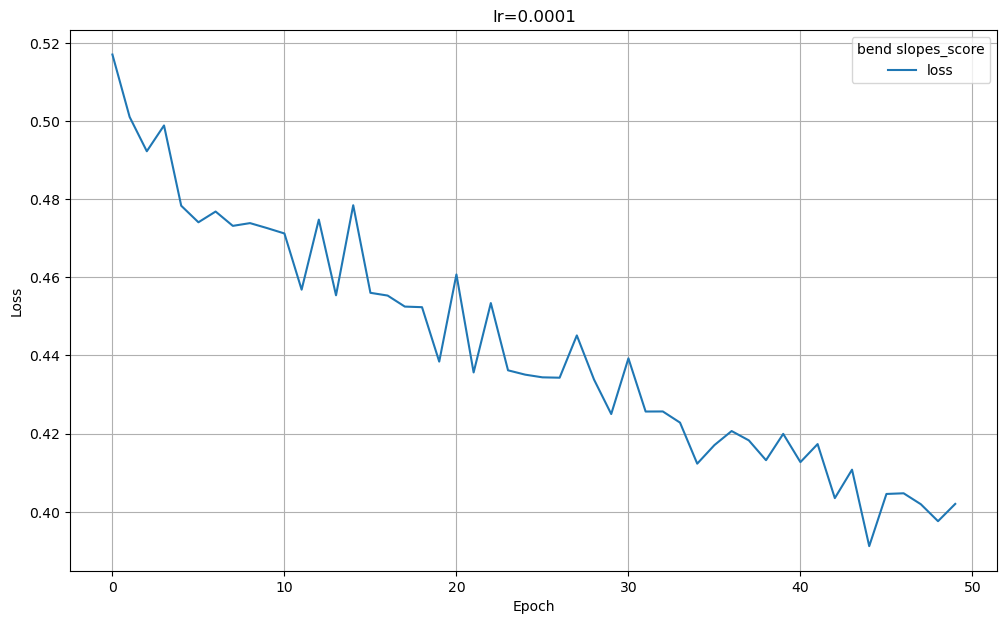

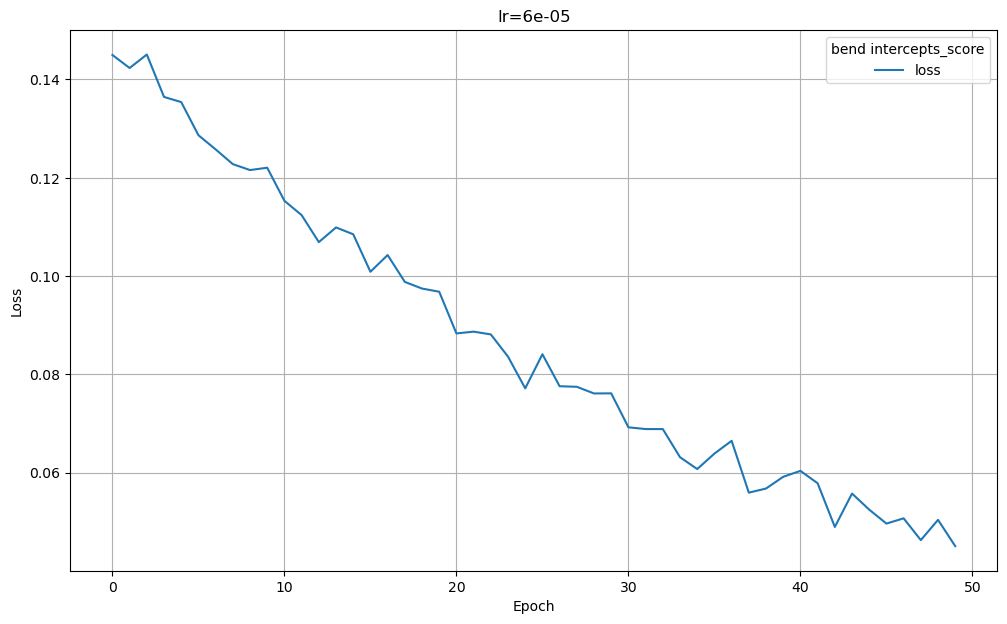

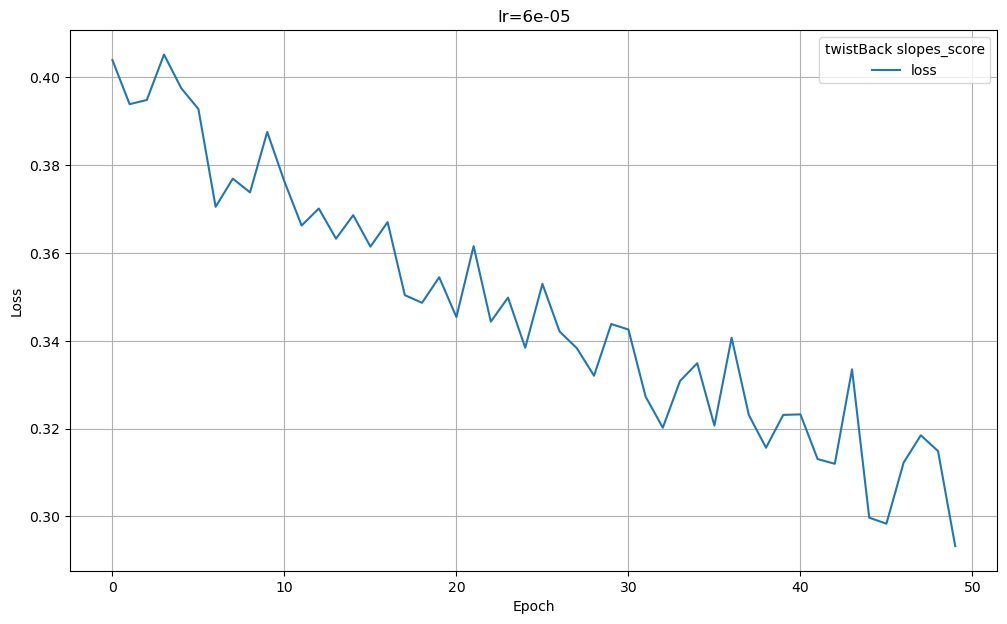

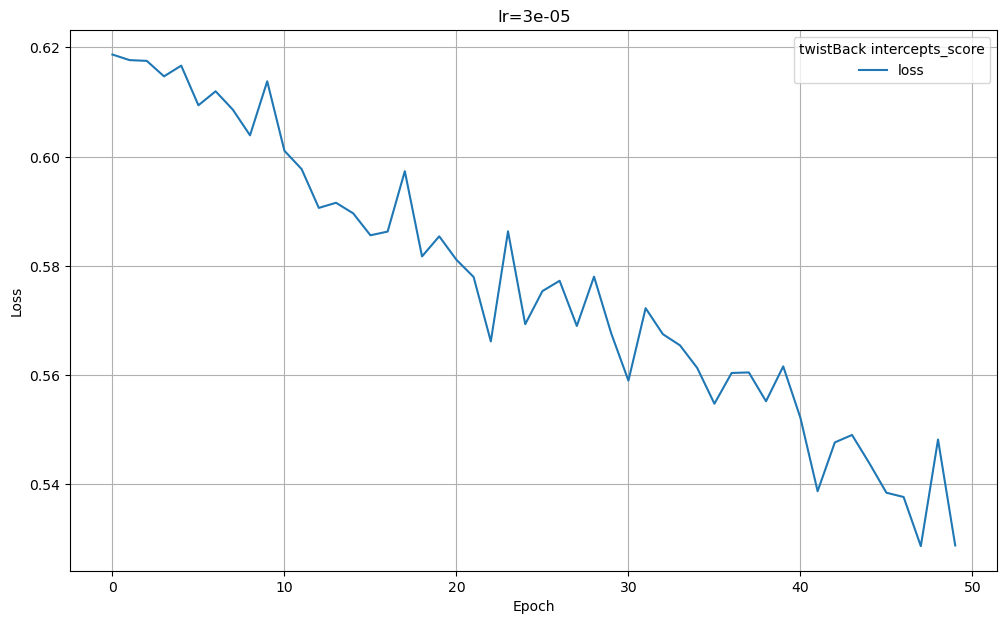

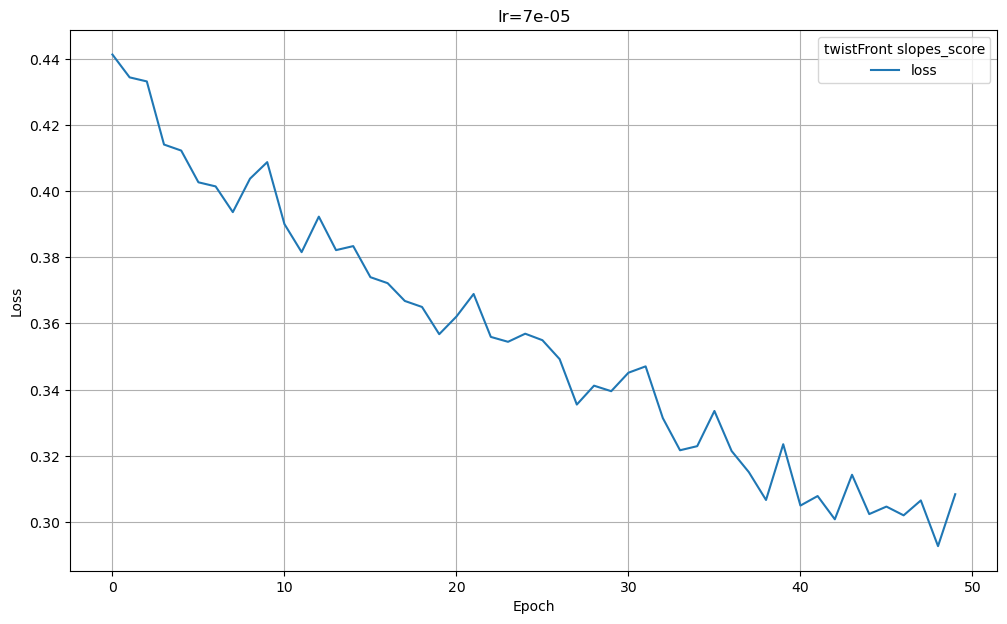

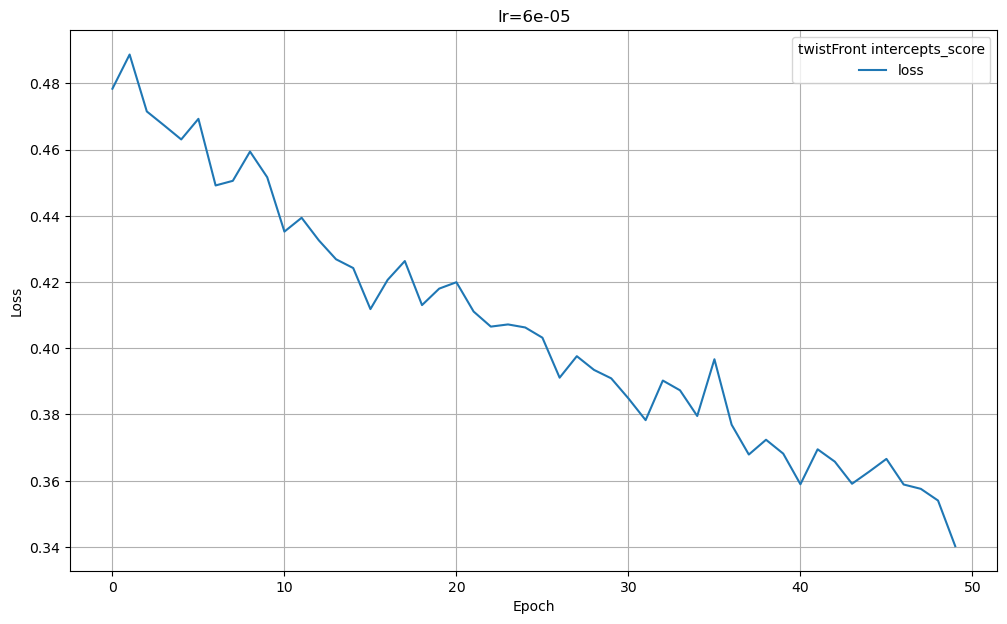

In [27]:
for i, result in enumerate(all_features_results_0):
    if best_lrs[0][i] is not None:
        show_single_loss(result[1], best_lrs[0][i], legend=result[0])
    else:
        show_nine_losses(result[1],lr_list,result[0])

In [28]:
# Use is_symetric data when plotting the dots

ValueError: in user code:

    c:\Users\matan\miniconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    c:\Users\matan\miniconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\matan\miniconda3\envs\myenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\matan\miniconda3\envs\myenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\matan\miniconda3\envs\myenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\matan\miniconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    c:\Users\matan\miniconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    c:\Users\matan\miniconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    c:\Users\matan\miniconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: [None, 8]


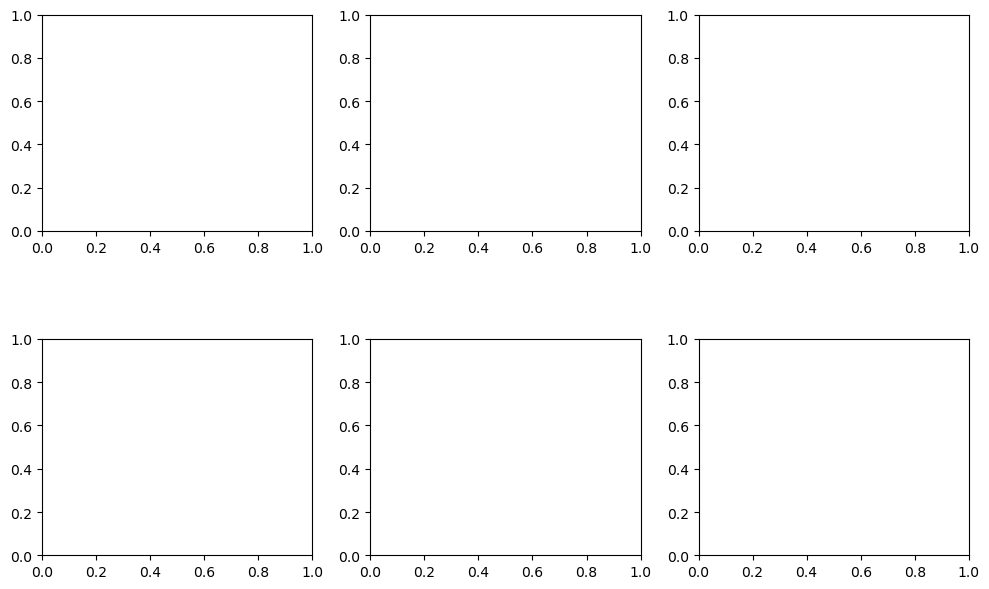

In [30]:
fig, axs = plt.subplots(2,3, figsize=(10, 6))
plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

for i, result in enumerate(all_features_results_0):
    j=int(i/3)
    k=i%3
    test_preds = result[2].predict(result[3])
    print(test_preds.shape)
    print(result[4].shape)
    axs[j][k].scatter(result[4], test_preds)
    axs[j][k].set_title(f'{result[0] }')
    axs[j][k].set_xlabel('True values')
    axs[j][k].set_ylabel('Predictions')
    axs[j][k].grid(True)
plt.show()

### b.1: Using smote to generate synthetic data

In [ ]:
all_features_results_1 = build_df_and_model(df_flag=1)

In [ ]:
for i, result in enumerate(all_features_results_1):
    if best_lrs[1][i] is not None:
        show_single_loss(result[1], best_lrs[1][i], legend=result[0])
    else:
        show_nine_losses(result[1],lr_list,result[0])

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(10, 6))
plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

for i, result in enumerate(all_features_results_1):
    j=int(i/3)
    k=i%3
    test_preds = result[2].predict(result[3])
    print(f'Prediction shape: {test_preds.shape}')
    print(f'Test shape: {result[4].shape}')
    axs[j][k].scatter(result[4], test_preds)
    axs[j][k].set_title(f'{result[0] }')
    axs[j][k].set_xlabel('True values')
    axs[j][k].set_ylabel('Predictions')
    axs[j][k].grid(True)
plt.show()

In [ ]:
for i, df in enumerate(wings_list_of_df):
    print(df[1])

### b.2: Using sdv (Statistic tools) to generate synthetic data

In [ ]:
all_features_results_2 = build_df_and_model(df_flag=2)

In [ ]:
for i, result in enumerate(all_features_results_2):
    if best_lrs[2][i] is not None:
        show_single_loss(result[1], best_lrs[2][i], legend=result[0])
    else:
        show_nine_losses(result[1],lr_list,result[0])

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(10, 6))
plt.tight_layout()
fig.subplots_adjust(hspace=0.5)

for i, result in enumerate(all_features_results_2):
    j=int(i/3)
    k=i%3
    test_preds = result[2].predict(result[3])
    print(f'Prediction shape: {test_preds.shape}')
    print(f'Test shape: {result[4].shape}')
    axs[j][k].scatter(result[4], test_preds)
    axs[j][k].set_title(f'{result[0] }')
    axs[j][k].set_xlabel('True values')
    axs[j][k].set_ylabel('Predictions')
    axs[j][k].grid(True)
plt.show()

### b.3: Trying to figure out the correlation between elastic and speed

In [ ]:
new_df = config.all_speed_df()
#ann_viz(model, view=True, title='')

In [ ]:
df_w_label.describe()
df_w_label.info()